<a href="https://colab.research.google.com/github/Poredaka1020/Projects_Data_Science/blob/main/Projet_Classification_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Exercice KNN

En raison de la simplicité du KNN pour la classification, nous nous concentrerons sur l'utilisation d'un outil PipeLine et d'un outil GridSearchCV, puisque ces compétences peuvent être généralisées pour tout modèle.


## Les données du Sonar 

### Détecter un rocher ou une mine

Un sonar (sound navigation ranging) est une technique qui utilise la propagation du son (généralement sous l'eau, comme dans la navigation sous-marine) pour naviguer, communiquer ou détecter des objets sur ou sous la surface de l'eau, comme d'autres navires.

<img src="https://moncoachdata.com/wp-content/uploads/MonCoachData-cours/sonar.jpg"  style="max-height: 500px; max-width: 500px;">

Le dataset contient les mesures de réponse pour 60 fréquences sonar distinctes envoyées contre un champ de mines connu (et des rochers connus). Ces fréquences sont ensuite étiquetées en fonction de l'objet connu sur lequel le son était dirigé (soit un rocher, soit une mine). 

<img src="https://moncoachdata.com/wp-content/uploads/MonCoachData-cours/mine.jpg"  style="max-height: 500px; max-width: 500px;">

Notre objectif principal est de créer un modèle de Machine Learning capable de détecter la différence entre un rocher et une mine sur la base de la réponse des 60 fréquences sonar distinctes.


Data Source : https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)



---

# Importations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# LECTURE CSV à éxécuter

# lecture à partir de Github pour pouvoir éxécuter le notebook sans se soucier d'importer le fichier csv
url = 'https://raw.githubusercontent.com/moncoachdata/MasterClass_DS_ML/main/sonar.all-data.csv'
df = pd.read_csv(url)

# Sinon lecture classique en important sur Google Colab ou depuis le chemin exact
# df = pd.read_csv("sonar.all-data.csv")

In [ ]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Exploration des Données

**Tâche : Créons une heatmap de la corrélation entre les différentes réponses en fréquence.**

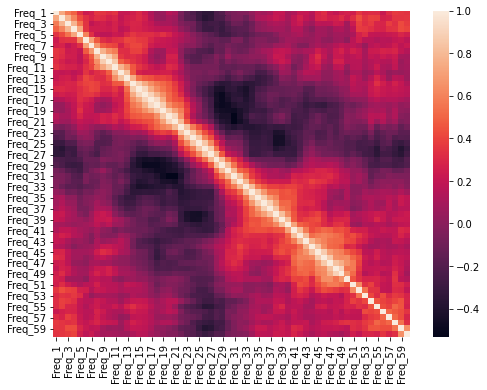

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=df.corr());

**Tâche : Quelles sont les 5 fréquences les plus corrélées avec la variable cible (label/target) ?**

*Note : Vous devrez souvent faire correspondre le label ou l'étiquette à des 0 et des 1.*

*Note supplémentaire : Nous recherchons des valeurs de corrélation **absolues**.*

In [ ]:
# Nous allons créer des valeurs factices pour transformer notre label en valeur numérique
df['Target'] = pd.get_dummies(df['Label'], drop_first=True)

In [ ]:
df['Target']

0      1
1      1
2      1
3      1
4      1
      ..
203    0
204    0
205    0
206    0
207    0
Name: Target, Length: 208, dtype: uint8

In [ ]:
abs(df.corr())['Target'].sort_values()[-6:]

Freq_45    0.339406
Freq_10    0.341142
Freq_49    0.351312
Freq_12    0.392245
Freq_11    0.432855
Target     1.000000
Name: Target, dtype: float64

In [ ]:
# df.drop('Label', axis=1, inplace=True)

In [ ]:
len(df.columns)

61

## Fractionnement Entraînement / Test

Notre approche ici consistera à utiliser la validation croisée (Cross Validation) sur 90% de l'ensemble de données, puis à juger nos résultats sur un ensemble de test final de 10% pour évaluer notre modèle.

**Tâche : Séparons les données en Features et en Label, puis divisons-les en un ensemble d'entraînement et un ensemble de test, avec 90 % pour l'entraînement (pour la validation croisée) et 10 % pour l'ensemble de test final.**

In [ ]:
X = df.drop('Target', axis=1)
y = df['Target']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Tâche : Créons un PipeLine qui contient à la fois un StandardScaler et un modèle KNN.**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
scaler = StandardScaler()
knn = KNeighborsClassifier()
operations = [('scaler', scaler), ('knn', knn)]
pipe = Pipeline(operations)

**Tâche : Effectuons une recherche par grille (GridSearch) avec le pipeline pour tester différentes valeurs de k et rapportons les paramètres les plus performants.**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
k_values = list(range(1, 30))
param_grid = {'knn__n_neighbors': k_values}

In [ ]:
grid_model_cv = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [ ]:
grid_model_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [ ]:
grid_model_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**Note**: D'après notre recherche par grille, nous voyons ici que le paramètre optimal pour k est 1

**Tâche (difficile) : En utilisant le dictionnaire .cv_results_, voyons si nous pouvons créer un graphique de la moyenne des scores de test (mean_test_score) par valeur K.**

In [ ]:
mean_scores = grid_model_cv.cv_results_['mean_test_score']

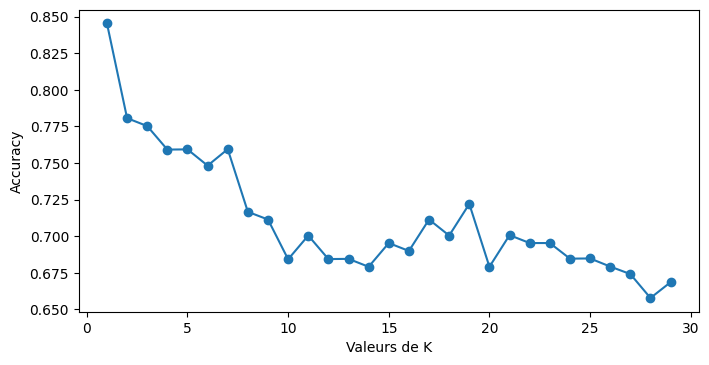

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(range(1, 30), mean_scores, marker='o')
plt.xlabel('Valeurs de K')
plt.ylabel("Accuracy");

## Évaluation finale du modèle

**Tâche : En utilisant l'objet de grille classificateur (grid classifier) de l'étape précédente, obtenons un rapport final de classification des performances et une matrice de confusion.**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
y_pred_cv = grid_model_cv.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_cv)

array([[12,  1],
       [ 1,  7]])

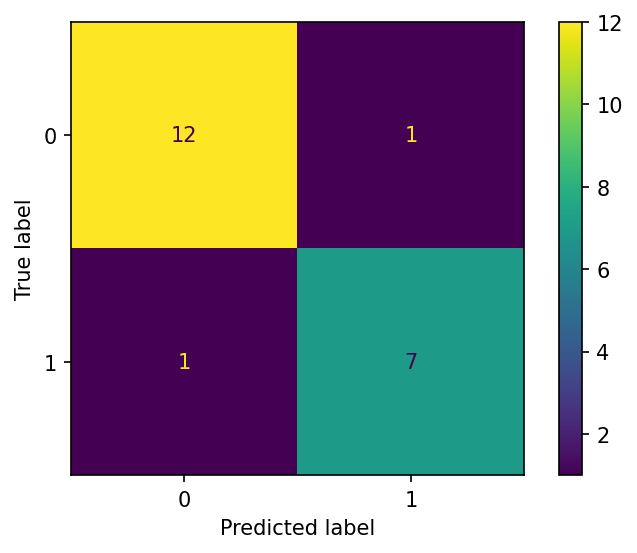

In [ ]:
fig, ax = plt.subplots(dpi=150)
ConfusionMatrixDisplay.from_estimator(grid_model_cv, X_test, y_test, ax=ax);

In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



**Conclusion**: Nous pouvons voir que le modèle, associé à une recherche par grille en utilisant la validation croisée afin de trouver le paramètre optimal pour k est quand-même plutôt bien.

A noter également que le jeu de données est très petit, mais il reste à savoir si les performances seront aussi bonnes pour un jeu de données conséquent 